# Odkrivanje skupin in izris kart dokumentov

Dimenzionalnost vektorskih predstavitev dokumentov lahko zmanjšamo na 2, kar nam omogoča prikaz dvodimenzionalne karte dokumentov, na kateri vsaka točka predstavlja dokument. Poleg tega lahko v dvodimenzionalnem prostoru odkrijemo skupine podobnih dokumentov in vsako skupino na karti obarvamo z različno barvo. To nam omogoča dober vpogled v celotno množico dokumentov.

Za začetek si spet preko API-ja pridobimo besedila zadnjih 100 predlogov vladi, ki vsebujejo vsaj 50 znakov ter iz datoteke preberemo fastText vektorje iz prejšnjega primera.

In [1]:
from textsemantics.server_api import ServerAPI
import numpy as np
from scipy.sparse import load_npz
import string
import nltk
nltk.download('stopwords', quiet=True)
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from lemmagen.lemmatizer import Lemmatizer
from lemmagen import DICTIONARY_SLOVENE

api = ServerAPI()
metadata = api.get_metadata('predlogi-vladi', sample_size=100, sampling_strategy='latest')

texts = api.get_texts(urls=metadata['text'])
texts = [text for text in texts if len(text) > 50]

def preprocess(corpus):
    stop_words = set(stopwords.words('slovene'))
    tokenizer = RegexpTokenizer("\w+")
    lemmatizer = Lemmatizer(dictionary=DICTIONARY_SLOVENE)
    
    preprocessed = list()
    for text in corpus:
        text = text.translate(text.maketrans('', '', string.punctuation))
        tokens = tokenizer.tokenize(text.lower())
        tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words 
                  and len(token) > 2 and not token.isnumeric()]
        preprocessed.append(tokens)
        
    return preprocessed

tokens_list = preprocess(texts)

ft = np.load('data/ft.npy')
    

Nato dokumente vložimo v dvodimenzionalni prostor, poiščemo skupine ter vsako skupino opišemo s specifičnimi besedami na način podoben tistemu, ki je opisan v zvezku `04_01_specific_words_with_embeddings`.

Število skupin: 4, Število dokumentov, ki niso v skupinah: 50


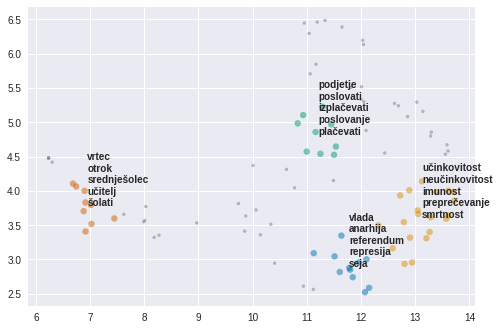

In [2]:
from umap import UMAP
from sklearn.cluster import DBSCAN
from utils.specific_words import prepare_data, find_cluster_words
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

umap = UMAP(n_neighbors=5, min_dist=0.0, metric='cosine', random_state=0).fit(ft)


dbscan = DBSCAN(min_samples=8).fit(umap.embedding_)
labels = dbscan.labels_
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)
palette = sns.color_palette('colorblind', n_clusters)
print(f"Število skupin: {n_clusters}, Število dokumentov, ki niso v skupinah: {n_noise}")


doc_embs, words, word_embs, word2doc, doc2word = prepare_data(tokens_list)
cluster_describer = find_cluster_words(doc_embs, words, word_embs, dbscan.labels_)

cs = [palette[l] if l > -1 else (0.5, 0.5, 0.5) for l in dbscan.labels_]
s = [36 if l > -1 else 9 for l in dbscan.labels_]
plt.scatter(umap.embedding_[:, 0], umap.embedding_[:, 1], c=cs,
            alpha=0.5, s=s);

for cluster, words in cluster_describer.items():
    centroid = np.mean(umap.embedding_[np.where(labels == cluster)[0], :], axis=0)
    ann = "\n".join(cluster_describer[cluster][:5])
    plt.text(centroid[0], centroid[1], ann, fontdict={'fontweight': 'bold'})

Poglejmo si bolj podrobno, kateri dokumenti se nahajajo v vsaki izmed odkritih skupin (prikazani so le trije dokumenti za vsako skupino). S tem se lahko prepričamo v smiselnost rezultatov.

In [3]:
from IPython.display import display, Markdown

mdstr = ''
for c in cluster_describer.keys():
    mdstr += f'\n\n# Skupina {c} ({", ".join(cluster_describer[c][:5])})'
    wh = np.where(labels == c)[0]
    for w in wh[:3]:
        mdstr += "\n - {}".format(texts[w].replace('\n', ''))
display(Markdown(mdstr))



# Skupina 0 (vlada, anarhija, referendum, represija, seja)
 - Ker je dosedanja vlada prepovedala referendume, predlagam, da se takoj uredi možnost sodelovanja vseh državljanov preko računalnika, s svojim digitalnim potrdilom.Vseh cca.1,5 milijona odraslih ljudi, bi morali sodelovati pri odločitvah vseh pomembnih zadev in ne le tista peščica v parlamentu.
 - Predlagam odstop celotne vlade RS, vključno z ministri in poslanci, ki nas imajo za norce in ustrahujejo narod in uvajajo ukrepe, ki škodijo. Dovolj je vse te represije in psihiranja, ustahovanja in laži in korupcije! Odstop vseh takoj!
 - Ker se po socialnih omrežjih širi vsak dan več laži, ki pozivajo k nespoštovanju ukrepov, o neobstoju epidemije, k nespoštovanju zakonov ipd, ljudje pa jim naivno verjamejo, predlagam, da se za določeno obdobje popolnoma ukine dostop do interneta, predvsem pa do Facebooka, Twitterja in kar je še podobnih orodij za širjenje teorij zarote.

# Skupina 1 (učinkovitost, neučinkovitost, imunost, preprečevanje, smrtnost)
 - Pozdravljeni,v času katastrofalnega naraščanja okužb v državi in s ciljem preprečevanja dodatnih rizičnih stikov predlagam, da v kolikor vodstvo Vrhovnega sodišča RS očitno ne ukrepa v skladu z epidemiološkim stanjem v državi, da Vlada sama presodi in sprejme ukrepe, ki bi zaustavili tek rokov in izvajanje narokov v vseh sodnih zadevah nenujne narave.Trenutno se namreč z nerazumljivim odlašanjem in očitnim dokazovanjem principov s strani vodstva Vrhovnega sodišča RS, pa tudi brezbrižnosti upravljavcev večjih odvetniških družb, ki iz naslonjačev pošiljajo v ogenj svoje "manj pomembne" podrejene, kaže razkorak v primerjavi z ukrepi na ostalih področjih kot so npr. neizvajanje nenujnih zdravstvenih storitev, ki pa so z vidika reševanja človekovega zdravja zagotovo pomembnejše od izvajanja pravosodnih organov v t.i. nenujnih sodnih zadevah. V slednjih se namreč udeležence sodnih postopkov (stranke, pooblaščene odvetnike, izvedence, sodno osebje itd.) celo v današnjih razmerah sili v interakcijo in tudi fizične stike, ki so sicer potrebni, da se zadosti izvedbi prekluzivnih sodnih rokov in narokov, medtem ko pa z vidika epidemiološke situacije v državi predstavljajo nezaželjenjo ustvarjanje stikov in nenazadnje v teh okoliščinah tudi neustrezen pritisk na same stranke, ki v postopkih pred sodiščih sicer iščejo svojo pravico, ne pa tudi izgubo zdravja.Hvala za pozornost in obravnavo ter skrb za zdravja in življenja ljudi ter nasplošno dobrobit državljanov.Lepo vas pozdravljam v želji, da se stanje v državi glede epidemiološkega stanja čimprej obrne na bolje.S spoštovanjem,Janez
 - Osredotočiti bi se moramo na preventivo. Zagotoviti zadostno količino vitamina C in D in ga brezplačno (!) nameniti državljanom. Dodatno še cink in druge naravnih snovi, ki lahko dejansko pomagajo telesu. In zdravju.Vlada naj takoj preveri spiske glavnih onesnaževalcev zraka in vod in jim najmanj omeji, ob stopnjevanju virusne krize pa prepove delovanje. Prav onesnaženost zraka je že bila znanstveno izpostavljena kot velik problem za širjenje virusa. Namesto milijonov za ljudi, ki jih aktualna politika napačno zapira domov in jim uničuje posle, bi sredstva namenili za nujno potrebno prestrukturiranje onesnaževalcev, kar bi tako ali tako morali narediti, če želimo samooskrbno Slovenijo, zgolj v pomoč nam je t.i. virusna kriza.K sodelovanju naj Vlada nemudoma povabi strokovnjake na področju komplemetnarne in integrativne medicine. Če kaj drži, je v času t.i. virusne krize ključni problem alopatske medicine, da ne zna celostno oceniti in detektirati izvorov nezdravja v telesu. Več kot jasno namreč je, da izključno virus ni vzrok smrtnosti, lahko pa je virus ali virusi v povezavi z drugimi bolezenskimi stanji. Tu nujno potrebujemo celostni pristop prej navedenih. Ki to znanje imajo. In ni jih malo!Tako je potrebno ukiniti bi vse programe obveznih cepljenj. Saj lahko prav cepljenje proti gripi (še posebej v jesensko-zimskem letnem času) vpliva s padcem imunosti tudi na dovzetnost za virus(e)! Za navedeno že obstajajo znanstvene študije in objave o morebitnem dogajanju v Bergamu glede na brezplačno cepljenje proti gripi konec leta 2019 za vse starejše od 65 let.Bistveno se morate posvetiti dvigovanju morale in optimizma državljanov. Z ves čas odprtimi vrtci, šolami in fakultetami. Brez zlorabe digitalne tehnologije, ki lahko negativno vpliva na razvoj predvsem otrok. In poudarku na vzgoji otrok z znanji preventive. In samooskrbe. Pomenu svežega zraka. Pitne vode. In narave.Brez zapiranj, omejitev in z načrtnimi sporočili o preventivi, pomenu gibanja na svežem zraku, pomenu zdrave hrane, izogibanja alkoholu in hkrati tobačnim izdelkom, ki tako ali drugače vplivajo na dihalne organe.V vrtcih, šolah, bolnicah, domovih za starejše in vseh javnih ustanovah je potrebno nemudoma prepovedati uporabo wifi tehnologije in ozaveščanje glede uporabe mobilnih podatkov. Takojšnja prekinitev postopkov glede nadaljevanja širitev brezžičnih telekomunikacijskih tehnologij (kot je 5g in podobno) na osnovi načela previdnosti in jasno navodilo telekomunikacijskih podjetjem, da aktivnosti usmerijo v optične povezave. Javne ozaveščevalne kampanje o škodljvosti elektromagnetnih sevanj brezžičnih tehnologij in predvsem o varni uporabi tehnologije. Tudi o varni uporabi mobilnih telefonov in tablic s priključitvijo na optično omrežje.Takojšnja prepoved proizvodnje, prodaje in uporabe strupov kot je glifosat. Načrtne subvencije za saooskrbo z ekološko pridelano hrano. Postopno prestrukruriranje od odvisnosti od uvoza (nezdrave) hrane.O vseh ukrepih v državi bi naj končno soodločajo strokovnjaki, ki nimajo konflikta interesov na področju medicine/imunologije, varstva okolja, gospodarstva, davkov in podobno. Nobena stroka ne sme prevladovati, išče naj se konsenz ukrepov. Policija in vojska sta lahko izključna podpora ljudem in nikakor ukrepom politike. In interesnih skupin. In skupin pritiska.Ni res, da se ne da. Ni res, da nimamo alternativ. Ni res, da nimamo izbire.
 - Pozdravljeni!Zadnje dni prihajajo po medijih do nas volivcev informacije, da je eden od naslednjih možnih ukrepov vlade z namenom zajezitve širjenja okužb s COVID 19 tudi ta, da bi nam omejili gibanje zgolj na naša stanovanja. Glede na to, da določen del prebivalstva svojega dela ne more opravljati na daljavo (zaposleni v zdravstvu) in bo še vedno obstajala možnost širjenja okužbe v delovnih okoljih, ter da za zdravje potrebujemo svež zrak, sonce in gibanje, podajam mnenje, da je tak ukrep nesmiseln.Moj predlog vladi je, da takega ukrepa ne sprejme. Barbara Prosen, dr. med., spec. anesteziologije, reanimatologije in perioperativne intenzivne medicinezaposlena v SB Novo mesto

# Skupina 2 (podjetje, poslovati, izplačevati, poslovanje, plačevati)
 - Menim, da bi morali v Sloveniji tako kot obdavčimo gospodinjstva in podjetja obdavčiti tudi verske institucije. Tako bi obdavčili vse verske obrede (maše, poroke, pogrebe). Če lahko Cerkev kupuje luksuzne nepremičnine v evropskih mestih, potem lahko tudi plačuje davke. S tem bi v državno blagajno priteklo več denarja, ki bi nam v teh časih še kako prav prišel.
 - V letošnjem letu se mnogi posamezniki kot tudi podjetja srečujejo s težavami povezanimi s COVID 19. Sam se bom osredotočil na problematiko subvencij - pomoči gospodarstvu. Zavedam se, da je v času v katerem se nahajamo potrebno pomagati gospodarstvu po najboljših močeh in zmožnostih. V preteklih mesecih je bil porabljen velik del sredstev vlade za ohranjanje delovnih mest in delovanja gospodarstva vsaj v nekih minimalnih okvirjih. Večji del podjetij in s.p.- jev je upravičeno do nadomestil a vem tudi za kar nekaj takih, ki v času krize ne iščejo rešitev vendar so zgolj osredotočena na pomoč vlade in zavestno zapirajo svoje obrate. So primeri, ko lastnik-ca obrata zapre svoja vrata in odpotuje na Kanarske na oddih ker računa na pomoč vlade. Zavedam se, da takih pijavk država ne more odkrivati, ker ima glede na razmere več ostalega dela a glede na omenjeno menim, da bi morala vlada na drugi strani razmisliti o spodbudah podjetjem, ki pa v času krize poslujejo zelo dobro in prispevajo ne mali delež k polnjenju državnih blagajn s plačili prispevkov. Moj predlog je, da bi takim podjetjem vlada znižala ( 15%) obdačitev ustvarjenega dobička za poslovno leto 2020 in tako nagradila podjetja, ki kljub krizi poslujejo in držijo gospodarstvo nad vodo. 
 - Predlagam, da se s.p.-jem omogoči mirovanje delovanja, namesto da se zapirajo, po krizi pa se bodo najverjetneje ponovno odpirali.

# Skupina 3 (vrtec, otrok, srednješolec, učitelj, šolati)
 - Pozdravljeni, kdaj boste dovolili registritanim športnikom, da se vrnejo na treninge? Gre za srednješolce, ki po starosti še niso člani, a jim bo počasi zmanjkalo volje, saj zaradi prekinitev nikakor ne pridejo do željene forme in s tem rezultatov...Športen pozdrav Anita Z.
 - Predlagam, da bi bili učenci v šoli, v mehurčku razreda, in učitelji, ki so doma zaradi izolacije ali karantene, pa na daljavo povezani z razredom. Seveda bi bilo dobro, da bi jih kontroliral kakšen prostovoljec, saj sicer ne bi bilo učinka (miru) z učenjem.Lep pozdrav.Ava Rajh
 - Otroci v prvih treh razredih osnovne šole se ne morejo šolati na daljavo, ne da bi starši pri tem sodelovali. Številni starši smo samozaposleni in si ne moremo vzeti dopusta, ne da bi pri tem utrpeli izpad dohodka, poleg tega imamo projekte, ki jih ne moremo kar odpovedati, ker bomo izgubili stranke in s tem dolgoročni vir dela in prihodkov.V prvem valu je bil način poučevanja prepuščen posameznim učiteljem in smo bili preuščeni sami sebi. Torej smo opravljali svoje delo in še delo učitelja. Po dveh mesecih smo bili starši izčrpani.Tudi če šola zagotovi pouk po zoomu, lahko to traja največ nekaj ur na dan, saj za majhne otroke ni primerno niti zdravo, da sedijo za računalniškimi ekrani ves dan. To pomeni, da je treba v preostalem delovnem času poskrbeti za varstvo, ki ga mnogi nimamo. Mnogi starši so tudi samohranilci, mnogi imajo po več otrok, ki so vsi v osnovni šoli. Mislim, da to, da otroci ostanejo doma, ni vzdržno.Če ne gre drugače, lahko tudi prepustite ravnateljem v posameznih občinah, da se glede na epidemiološko sliko v tisti občini odločijo, ali naj bo šola odprta ali ne in za katere razrede. 